In [3]:
# 1. MOUNTING DRIVE & INSTALLS
from google.colab import drive
drive.mount('/content/drive')

!pip install category_encoders optuna pytorch-tabnet xgboost scikit-learn imbalanced-learn shap scikeras

# 2. IMPORTS
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from pytorch_tabnet.tab_model import TabNetClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import VotingClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import shap
import torch

# 3. LOAD DATA
df = pd.read_csv('/content/drive/MyDrive/Project/DataSet/WA_Fn-UseC_-HR-Employee-Attrition.csv')  # update path

# 4. FEATURE ENGINEERING (Ethical and Transparent)
drop_cols = ['EmployeeNumber', 'EmployeeCount', 'StandardHours', 'Over18']
df = df.drop(columns=[col for col in drop_cols if col in df.columns])
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# Burnout Score
if 'OverTime' in df.columns and 'JobSatisfaction' in df.columns:
    df['OverTime'] = df['OverTime'].map({'Yes': 1, 'No': 0})
    df['BurnoutScore'] = df['OverTime'] * (5 - df['JobSatisfaction'])

# Engagement Score
engagement_features = ['JobSatisfaction', 'EnvironmentSatisfaction', 'WorkLifeBalance']
df['EngagementScore'] = df[engagement_features].mean(axis=1)

# Economic Signal (mocked, ideally from macro sources)
df['EconomicIndicator'] = np.random.normal(0, 1, df.shape[0])

df = pd.get_dummies(df)

# 5. HANDLE IMBALANCE (SMOTE)
X = df.drop('Attrition', axis=1)
y = df['Attrition']
sm = SMOTE()
X_res, y_res = sm.fit_resample(X, y)

# 6. TRAIN-TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.15, stratify=y_res, random_state=42)

# 6.5 STANDARDIZATION
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 7. FEATURE SELECTION
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
selector = RFECV(XGBClassifier(random_state=42), step=1, cv=5, scoring='accuracy', n_jobs=-1)
selector.fit(X_train_scaled, y_train)
X_train_sel = selector.transform(X_train_scaled)
X_test_sel = selector.transform(X_test_scaled)

# 8. OPTUNA FOR XGBOOST
import optuna
from sklearn.model_selection import cross_val_score

def optuna_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }
    clf = XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss')
    return cross_val_score(clf, X_train_sel, y_train, cv=3, scoring='accuracy').mean()

study = optuna.create_study(direction='maximize')
study.optimize(optuna_xgb, n_trials=30)
best_xgb = XGBClassifier(**study.best_params, use_label_encoder=False, eval_metric='logloss')
best_xgb.fit(X_train_sel, y_train)

# 9. OPTUNA FOR TABNET
def optuna_tabnet(trial):
    clf = TabNetClassifier(
        n_d=trial.suggest_int('n_d', 8, 64),
        n_a=trial.suggest_int('n_a', 8, 64),
        n_steps=trial.suggest_int('n_steps', 3, 10),
        gamma=trial.suggest_float('gamma', 1.0, 2.0),
        lambda_sparse=trial.suggest_float('lambda_sparse', 1e-6, 1e-3, log=True),
        seed=42, verbose=0
    )
    scores = cross_val_score(clf, X_train_sel, y_train, cv=3, scoring='accuracy')
    return scores.mean()

study2 = optuna.create_study(direction='maximize')
study2.optimize(optuna_tabnet, n_trials=20)
best_tabnet = TabNetClassifier(**study2.best_params, seed=42, verbose=0)
best_tabnet.fit(X_train_sel, y_train)

# 10. GRU MODEL WRAPPER
from sklearn.base import BaseEstimator, ClassifierMixin
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

class GRUWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim=None, epochs=30, batch_size=32):
        self.epochs = epochs
        self.batch_size = batch_size
        self.input_dim = input_dim

    def build_model(self):
        model = Sequential()
        model.add(Dense(64, input_shape=(self.input_dim,), activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
        return model

    def fit(self, X, y):
        self.input_dim = X.shape[1]
        self.model = self.build_model()
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        return self

    def predict_proba(self, X):
        preds = self.model.predict(X)
        return np.hstack([(1 - preds), preds])

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype("int32")

# Instantiate GRU
gru_model = GRUWrapper()
gru_model.fit(X_train_sel, y_train)

# 11. MANUAL SOFT VOTING ENSEMBLE
xgb_proba = best_xgb.predict_proba(X_test_sel)
tabnet_proba = best_tabnet.predict_proba(X_test_sel)
gru_proba = gru_model.predict_proba(X_test_sel)
avg_proba = (xgb_proba + tabnet_proba + gru_proba) / 3
y_pred = np.argmax(avg_proba, axis=1)

# 12. EVALUATION
print("✅ Final Accuracy (Fair-ExplainHR Ensemble):", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[I 2025-12-20 12:02:30,931] A new study created in memory with name: no-name-bc558c9a-40c5-40a3-b9d8-67817e4bf801
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:02:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:02:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:02:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-12-20 12:02:31,396] Trial 0 finished with value: 0.9279588933843271 and parameters: {'n_estimators': 208, 'max_depth': 4, 'learning_rate': 0.2079883667914837, 'subsample': 0.8307528446489667, 'colsample_

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✅ Final Accuracy (Fair-ExplainHR Ensemble): 0.9216216216216216
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       185
           1       0.96      0.88      0.92       185

    accuracy                           0.92       370
   macro avg       0.92      0.92      0.92       370
weighted avg       0.92      0.92      0.92       370



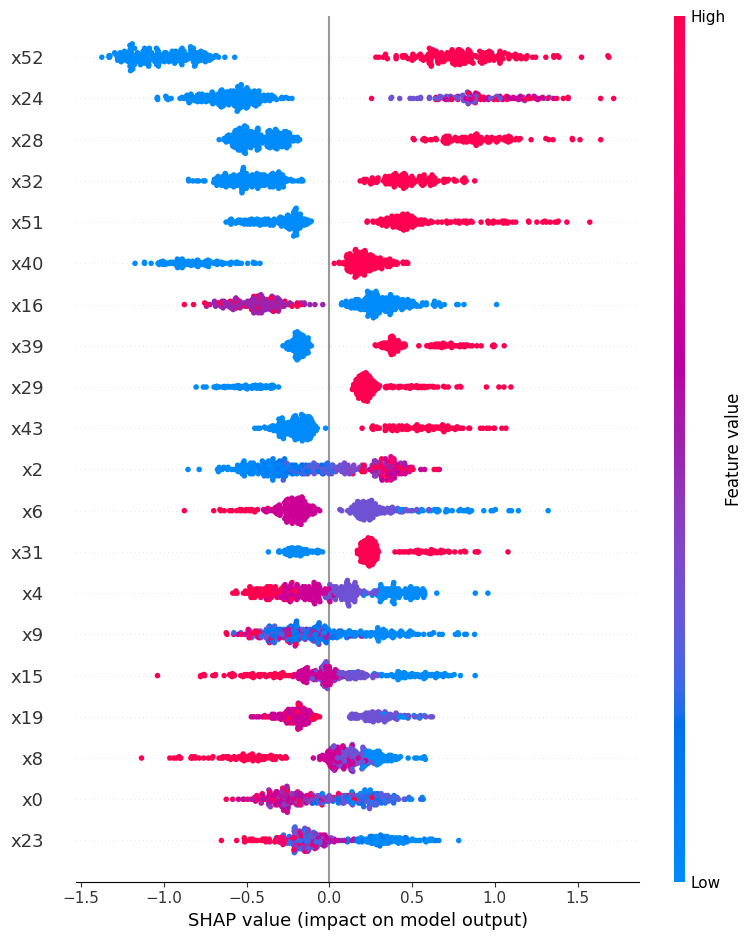

In [4]:
import shap

# SHAP for XGBoost
explainer_xgb = shap.TreeExplainer(best_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_test_sel)

shap.summary_plot(
    shap_values_xgb,
    X_test_sel,
    feature_names=selector.get_feature_names_out()
)


In [5]:
import shap
import matplotlib.pyplot as plt

shap.initjs()


In [6]:
explainer_xgb = shap.TreeExplainer(best_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_test_sel)

feature_names = selector.get_feature_names_out()


In [9]:
shap.summary_plot(
    shap_values_xgb,
    X_test_sel,
    feature_names=feature_names,
    show=False
)

plt.savefig(
    "/content/drive/MyDrive/Project/shap_summary.png",
    dpi=300,
    bbox_inches="tight"
)
plt.close()


In [10]:
force_plot = shap.force_plot(
    explainer_xgb.expected_value,
    shap_values_xgb[0],     # one employee
    X_test_sel[0],
    feature_names=feature_names
)

shap.save_html(
    "/content/drive/MyDrive/Project/shap_force_plot.html",
    force_plot
)


In [11]:
shap.summary_plot(
    shap_values_xgb,
    X_test_sel,
    feature_names=feature_names,
    plot_type="bar",
    show=False
)

plt.savefig(
    "/content/drive/MyDrive/Project/shap_bar.png",
    dpi=300,
    bbox_inches="tight"
)
plt.close()


In [ ]:
import joblib
import pickle

# Create directory for saved models
import os
os.makedirs('/content/drive/MyDrive/Project/Models', exist_ok=True)

# Save XGBoost model
best_xgb.save_model('/content/drive/MyDrive/Project/Models/xgb_model.json')

# Save TabNet model
best_tabnet.save_model('/content/drive/MyDrive/Project/Models/tabnet_model.zip')

# Save GRU model (Keras)
gru_model.model.save('/content/drive/MyDrive/Project/Models/gru_model.h5')

# Save scaler and feature selector
joblib.dump(scaler, '/content/drive/MyDrive/Project/Models/scaler.pkl')
joblib.dump(selector, '/content/drive/MyDrive/Project/Models/feature_selector.pkl')

print("✅ All models and preprocessing objects saved successfully.")


Successfully saved model at /content/drive/MyDrive/Project/Models/tabnet_model.zip.zip
✅ All models and preprocessing objects saved successfully.


In [ ]:
import json
import os

# Make sure directory exists
os.makedirs("/content/drive/MyDrive/Project/Models1", exist_ok=True)

# Save column names for backend use
columns = list(X.columns)
with open("/content/drive/MyDrive/Project/Models1/columns.json", "w") as f:
    json.dump(columns, f)

print("✅ columns.json saved successfully!")


✅ columns.json saved successfully!


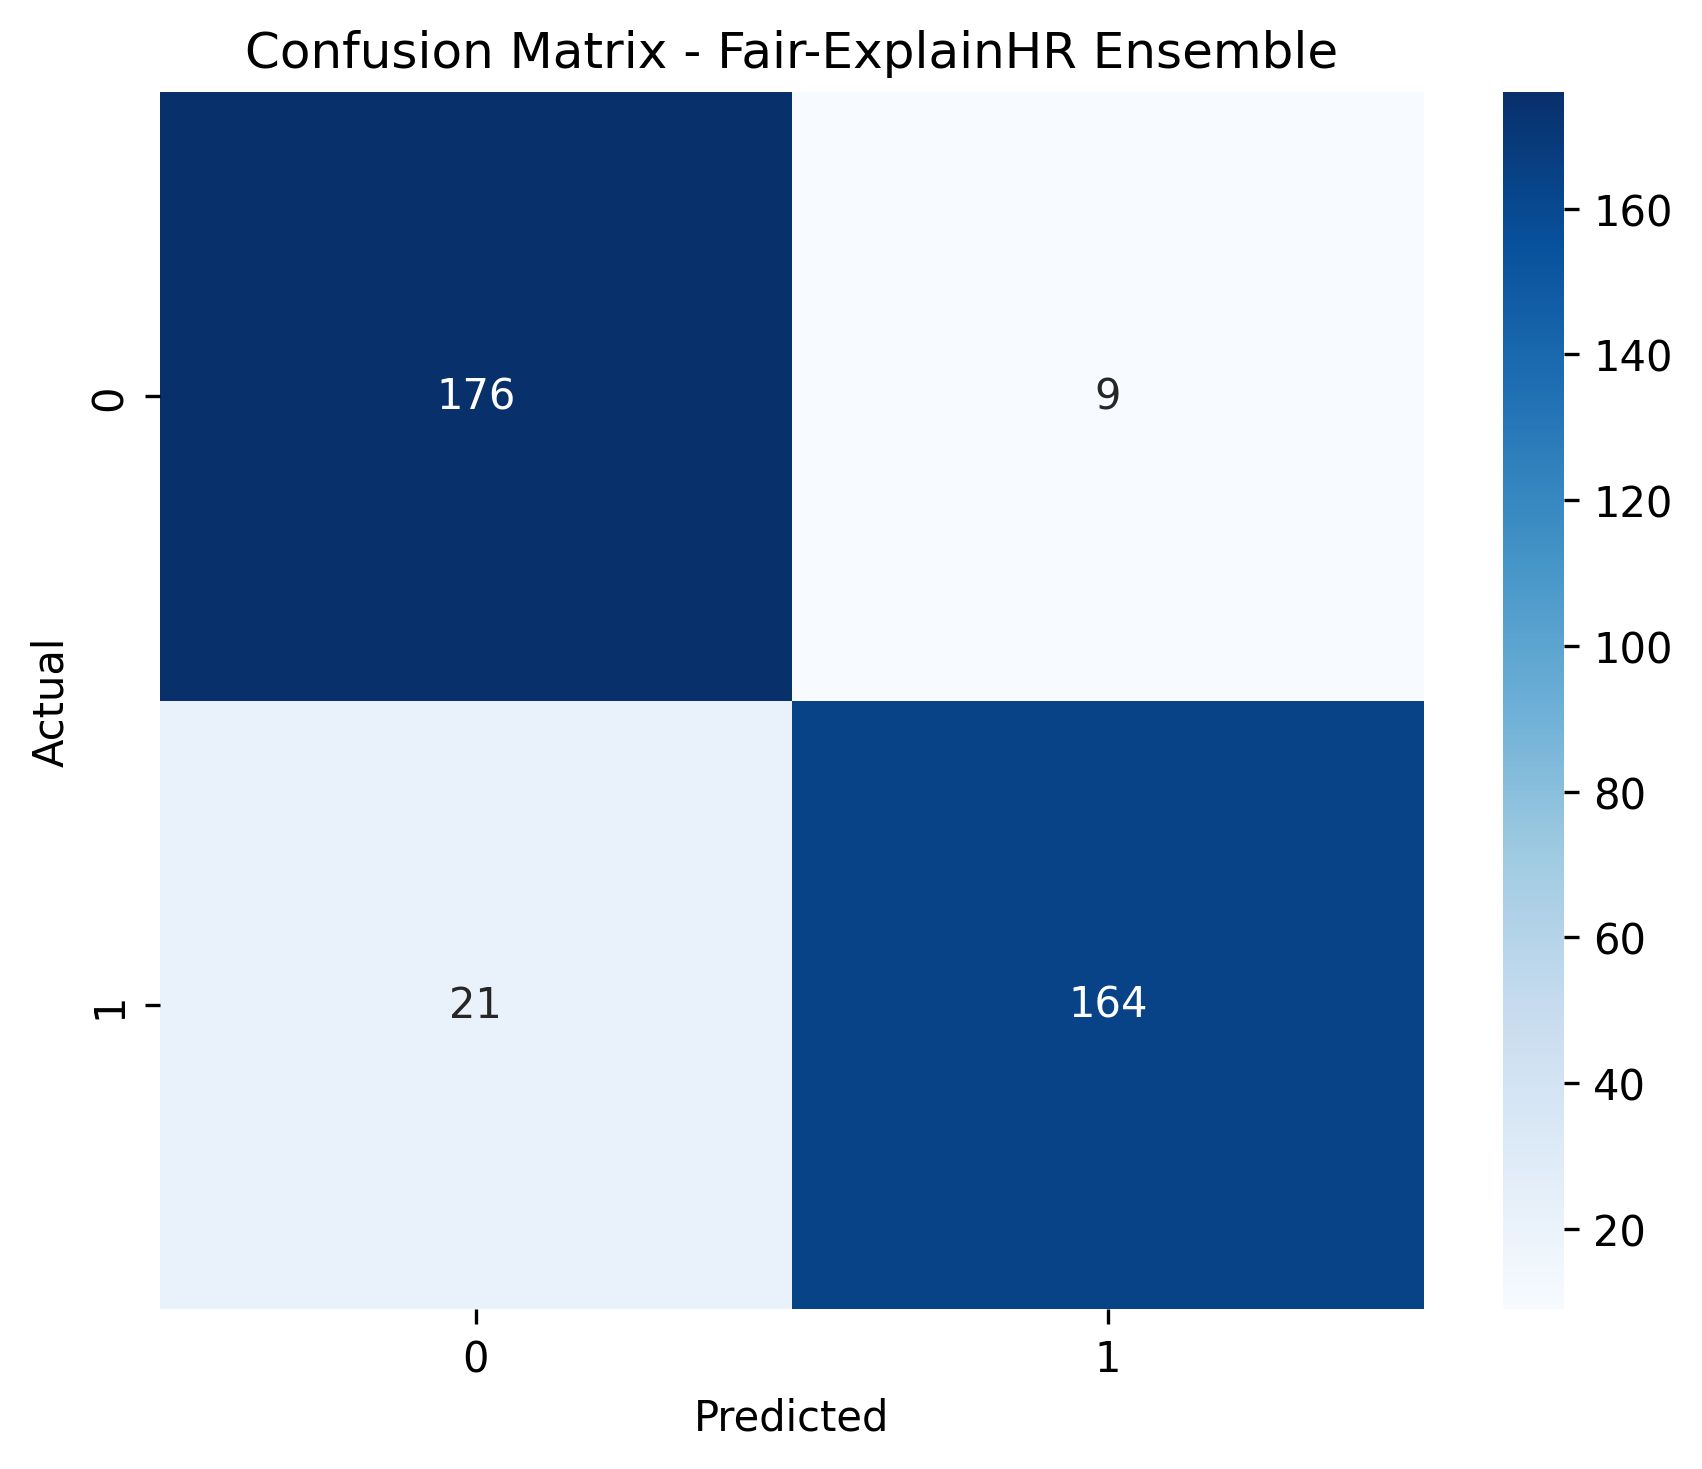

In [ ]:
# 13. CONFUSION MATRIX (IEEE-format Ready)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot high-resolution matrix
plt.figure(figsize=(6,5), dpi=300)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Fair-ExplainHR Ensemble")
plt.tight_layout()

# Save for IEEE paper
plt.savefig("confusion_matrix_highres.png", dpi=300)
plt.show()
